In [61]:
from keras import layers
import pandas as pd
from keras.layers import Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D,Input, Dense
from keras.models import Model
from matplotlib.pyplot import imshow
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [36]:
traindf = pd.read_csv("data/training.csv")
testdf =pd.read_csv("data/test.csv")
print(  type(traindf.iloc[0]['Image']))
# before 'Image' is stored as string, it is converted to matrix
traindf['Image'] = traindf['Image'].apply(lambda im: np.fromstring(im, sep=' '))
testdf['Image'] = testdf['Image'].apply(lambda im: np.fromstring(im, sep=' '))

<class 'str'>


In [37]:
# print(traindf.head)

In [18]:
# print(traindf.iloc[0]['Image'].shape)

(9216,)


In [38]:
print(  type(traindf.iloc[0]['Image']))

<class 'numpy.ndarray'>


In [16]:
 print(traindf.shape)

(7049, 31)


In [39]:
print(  traindf.isnull().any(axis=1).shape )

(7049,)


In [41]:
# examples having missing values
# (4909, 31)
missdf =traindf[traindf.isnull().any(axis=1) ]

In [53]:
missX = np.vstack(missdf['Image'].values)/255
missX = missX.astype(np.float32)
missX = missX.reshape(missX.shape[0], 96,96,1)

missY = missdf.drop('Image', axis=1).values

In [42]:

traindf1 = traindf[traindf.isnull().any(axis=1)!=1 ]

print( type(traindf1.iloc[1]['Image'] ))

X_train = np.vstack(traindf1['Image'].values)/255
X_train = X_train.astype(np.float32)
X_train = X_train.reshape(X_train.shape[0], 96,96,1)

np.random.shuffle(X_train)

Y_train= traindf1.drop('Image', axis=1).values
Y_train = (Y_train-48)/48
Y_train =Y_train.astype(np.float32)

<class 'numpy.ndarray'>


In [44]:
print(Y_train.shape)
print(X_train.shape)

(2140, 30)
(2140, 96, 96, 1)


In [ ]:
def flipimages():
    X_flip= []
    X= tf.placeholder(tf.float32, shape =(96,96,1))
    img1 = tf.img.flip_left_right(X)
    with tf.session() as sess:
        sess.run(global_variables_initializer())
        for i in range(X_train.shape[0])
            flipimg = sess.run{X_train[i], feed={X: img}}
            flipimgy = - Y_train[i]
            np.append(X_train, flipimg , axis=0 )
            np.append(Y_train, flipimgy, axis=0) 

In [45]:
def lenetmodel(input_shape):
    X_input = Input(input_shape) # input_shape = (96,96)
    X = X_input
    
    X= Conv2D(6, (5,5), strides=(1,1),padding='same', name='conv1')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((2,2))(X)
    X = Activation('relu')(X)
    
    X= Conv2D(16, (5,5), strides=(1,1), name= 'conv2')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((2,2))(X)
    X = Activation('relu')(X)
    
    X= Conv2D(16, (5,5), strides=(1,1), name= 'conv3')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D((2,2))(X)
    X = Activation('relu')(X)    
    
    X= Flatten()(X)
    X = Dense(512 , input_dim=(2304,))(X)
    X = Activation('relu')(X)
    X =  Dense(120, input_dim=(512,))(X)
    X = Activation('relu')(X)
    X = Dense(30, input_dim=(120,))(X)
        
    model = Model(inputs= X_input, outputs= X, name='lenet-5' )
    return model;

In [46]:
model = lenetmodel((96,96,1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs = 100, batch_size = 128)

Epoch 1/100
2140/2140 [==============================] - 26s 12ms/step - loss: 0.1812 - acc: 0.0841
Epoch 2/100
2140/2140 [==============================] - 33s 15ms/step - loss: 0.0251 - acc: 0.2472
Epoch 3/100
2140/2140 [==============================] - 30s 14ms/step - loss: 0.0102 - acc: 0.5145
Epoch 4/100
2140/2140 [==============================] - 32s 15ms/step - loss: 0.0072 - acc: 0.6350
Epoch 5/100
2140/2140 [==============================] - 28s 13ms/step - loss: 0.0065 - acc: 0.6533
Epoch 6/100
2140/2140 [==============================] - 24s 11ms/step - loss: 0.0061 - acc: 0.6626
Epoch 7/100
2140/2140 [==============================] - 25s 11ms/step - loss: 0.0059 - acc: 0.6621
Epoch 8/100
2140/2140 [==============================] - 25s 12ms/step - loss: 0.0057 - acc: 0.6626
Epoch 9/100
2140/2140 [==============================] - 24s 11ms/step - loss: 0.0057 - acc: 0.6701
Epoch 10/100
2140/2140 [==============================] - 26s 12ms/step - loss: 0.0058 - acc: 0.6584

KeyboardInterrupt: 

In [75]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 96, 6)         156       
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 6)         24        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 6)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 6)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 44, 44, 16)        2416      
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 16)        64        
__________

In [56]:

output = model.predict(missX, batch_size=128 )
for i in range(len(missX)):
    for j in range(30):
        if( pd.isnull(missY[i][j]) ):
            missY[i][j] = output[i][j]                

In [58]:

missY = (missY-48)/48
missY = missY.astype(np.float32)

In [59]:
model.fit(missX, missY, epochs = 10, batch_size = 128)

Epoch 1/10
4909/4909 [==============================] - 58s 12ms/step - loss: 0.1819 - acc: 0.6087
Epoch 2/10
4909/4909 [==============================] - 65s 13ms/step - loss: 0.0260 - acc: 0.9682
Epoch 3/10
4909/4909 [==============================] - 59s 12ms/step - loss: 0.0263 - acc: 0.9690
Epoch 4/10
4909/4909 [==============================] - 67s 14ms/step - loss: 0.0241 - acc: 0.9713
Epoch 5/10
4909/4909 [==============================] - 62s 13ms/step - loss: 0.0232 - acc: 0.9711
Epoch 6/10
4909/4909 [==============================] - 56s 11ms/step - loss: 0.0224 - acc: 0.9711
Epoch 7/10
4909/4909 [==============================] - 56s 11ms/step - loss: 0.0227 - acc: 0.9709
Epoch 8/10
4909/4909 [==============================] - 60s 12ms/step - loss: 0.0230 - acc: 0.9703
Epoch 9/10
4909/4909 [==============================] - 55s 11ms/step - loss: 0.0235 - acc: 0.9699
Epoch 10/10
4909/4909 [==============================] - 54s 11ms/step - loss: 0.0220 - acc: 0.9699


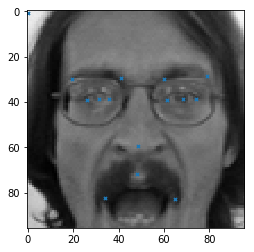

In [88]:
k =3
image = np.round(missX[k] * 255)

plt.imshow(image.reshape(96,96), cmap ='gray' )
plt.scatter( missY[k][0::2] * 48 + 48, missY[k][1::2] * 48 + 48, marker='x', s=10)

plt.show()

In [76]:
model.save('my_model_final.h5')